# Battle of Neighborhoods - Part 2

### Japanese Restaurants in NYC

 by Jiro Stenger

## Introduction/Business Problem

### Foreword

The following assumptions and elaborations are kept very simple, since this is a fictitious project. In order to obtain a more professional evaluation, a lot more research would have to be done and more variables would have to be considered.

### Introduction

The goal of the project is to find out the best locations for a Japanese restaurant in New York City. Nowadays, the Japanese cuisine is among the most popular cuisines worldwide (Nippon.com, 2016). Given the fact, that living in New York and especially in Manhatten is expensive, there could be a high acceptance in NYC for the rather high pricing Japanese cuisine (Investopedia, 2019). Hence, NYC might be an interesting city to open a Japanese restaurant, serving for example Sushi or other delicate Japanese specialties.

### Business Problem:

A client wants to open a major Japanese restaurant in NYC, serving traditional Japanese food prepared in a modern way. The client is aware there is lots of competition in a city like NYC. The investment, that is needed to open the restaurant, is very high, so the client needs recommendation on the location to choose for the venue. He needs to know where the Japanese restaurants are located, so he can either open the restaurant in an area that is famous for Japanese cuisine or in an area without much competition. Therefore, in order to get a better feeling of who could be competitors and who partners, the client needs to know which Japanese restaurants serve what kind of Japanese food. For example, a Ramen restaurant would not be a direct competitor to a Sushi Restaurant.

After a little research, I found there is a neighborhood called "little Tokyo". It is supposed to be located in the East Village between St. Mark's Place and 10th Street (Source: Beacon Hotel, 2018). I will attempt to prove, if there is actually a neighborhood in NYC with a high quantity of Japanese restaurants as well as whether the location stated before is correct or not.

In conclusion, this report explores which boroughs and neighborhoods in New York City have the most Japanese restaurants and what kind of food they serve. In the end, the explored restaurants will be clustered to see if there is a correlation between the restaurants, the type of food they serve and their location. 

---

## Data

There is various data required to answer the questions above. Since we do not have one data set with all the required data, we will have to obtain our data from several data sources. First of all, we need data on boroughs and neighborhoods of New York City. Also, we need data of restaurants and their location with latitute and longitute as well as their menus.

We will get the data on neighborhoods, boroughs, latitudes and longitudes from the following GeoJSON: 
https://cocl.us/new_york_dataset

The data on neighborhood boundaries of NYC we will obtain from here: 
https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Lastly, we will get the data on Japanese restaurants and the type of food they serve as well as their geo coordinates via the FourSquare API and request library.

---

## Methodology

First, we will collect the described data from the section above. After that, we will clean and process it into a dataframe. We will use FourSquare data to locate all the restaurants and filter down to the Japanese ones. Next, we will take a look at the neighborhoods and boroughs of NYC and locate the Japanese restaurants in the areas. Using matplotlib and folium, we will visualize our data to get a better understanding of it.  After that, we will get the menus of the restaurants by FourSquare and add them to the dataframe. In the end we will use the data of the restaurants menu to cluster the restaurants using K-means.

---

### Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

print('Done!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

### Functions

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_menu(VENUE_ID):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/VENUE_ID/menu/venue_id={}&client_id={}&client_secret={}&v={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    menu_data=results['response']
    menu_details=[]
    try:
        menu_id=menu_data['menuId']
        menu_name=menu_data['name']
        menu_description=menu_data['description']
        venue_details.append([menu_id,menu_name,menu_description])
    except KeyError:
        pass
    column_names=['MenuID','Name','Description']
    df = pd.DataFrame(menu_details,columns=column_names)
    return df

#### My Data

In [3]:
CLIENT_ID = '...' #  Foursquare ID
CLIENT_SECRET = '...' #  Foursquare Secret
VERSION = '20180604'
LIMIT = 100

#### NYC Data

In [4]:
ny_data = get_new_york_data()
ny_data.head(20)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [5]:
ny_data.shape

(306, 4)

We see that we have a total of 306 neighborhoods. Now we will visualize the distribution of the neighborhoods per borough in order to get a better understanding.

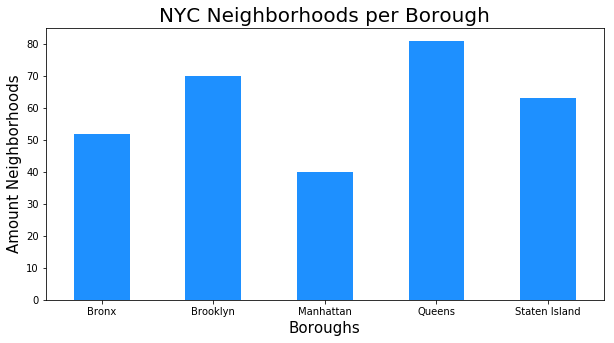

In [6]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('NYC Neighborhoods per Borough', fontsize = 20)
plt.xlabel('Boroughs', fontsize = 15)
plt.ylabel('Amount Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Queens has the most and Manhatten the least neighborhoods.

Now we will analyze the restaurants. We need to know how many Japanese restaurants are in each neighborhood and burough.

In [7]:
# we prepare the neighborhood list with Japanese restaurants and their location 
column_names=['Borough', 'Neighborhood', 'ID','Name','Lat','Lng']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for restaurant_detail in japanese_restaurants.values.tolist():
        id, name , category=restaurant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name': name,
                                                    'Lat': Latitude,
                                                    'Lng': Longitude
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

Now we save the data due to limited API calls

In [8]:
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [9]:
japanese_rest_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny

,Unnamed: 0,Borough,Neighborhood,ID,Name,Lat,Lng
0,0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi,40.642382,-73.980421
1,1,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki,40.676822,-73.964859
2,2,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan,40.707144,-73.958115
3,3,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude,40.687232,-73.941785
4,4,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House,40.695864,-73.993782
5,5,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino,40.687920,-73.998561
6,6,Brooklyn,Fort Greene,5739c66c498e7ef6085cec4f,Karasu,40.688527,-73.972906
7,7,Brooklyn,Park Slope,5276d39a498eb1a5d90096e4,Sushi Katsuei,40.672321,-73.977050
8,8,Brooklyn,Park Slope,3fd66200f964a5208af11ee3,Yamato,40.672321,-73.977050
9,9,Brooklyn,Clinton Hill,4e3cadcb1f6e844231dbe017,Waza,40.693229,-73.967843


In [10]:
japanese_rest_ny.shape

(75, 7)

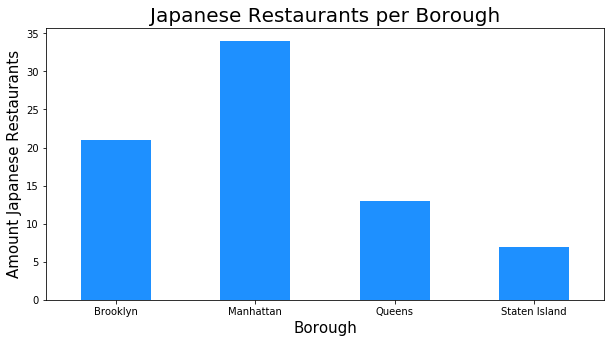

In [11]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Japanese Restaurants per Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Amount Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Surprisingly, there is supposed to be no Japanese Restaurant in the borough Bronx. I had to double check with Google Maps and it's true, there are currently 0 Japanese Restaurants in the borough.

Also, although Manhatten had the least amount of neighborhoods, it has the highest number of Japanese Restaurants. There might be a correlation with the expensive borough Manhatten and the expensive Japanese cuisine. This is something that could be evaluated as a follow up.

For now, let's take a look at which neighborhood has the most Japanese restaurants. As mentioned in the introduction, "little Tokyo" is located in East Village (between St. Mark's Place and 10th Street). Hence, we can expect the neighborhood East Village to have the most Japanese restaurants.

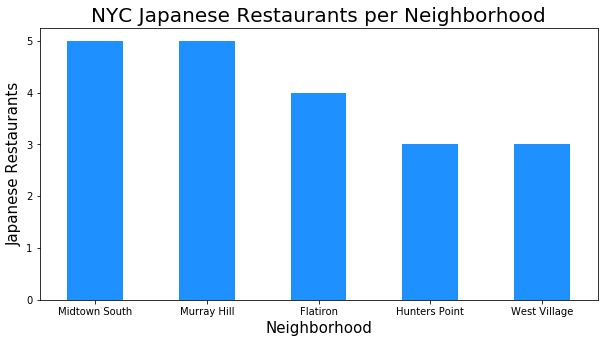

In [12]:
japanese_rest_neighborhood = 5 
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(japanese_rest_neighborhood).plot.bar(figsize=(10,5), color=clr)
plt.title('NYC Japanese Restaurants per Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Surprisingly, East Village is not even among the top 5 neighborhoods. Let's take a look at East Village in detail.

In [13]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='East Village']

,Unnamed: 0,Borough,Neighborhood,ID,Name,Lat,Lng
31,31,Manhattan,East Village,510c85e7e4b0056826b88297,Kura,40.727847,-73.982226
32,32,Manhattan,East Village,47af5dd2f964a5209f4d1fe3,Kyo Ya,40.727847,-73.982226


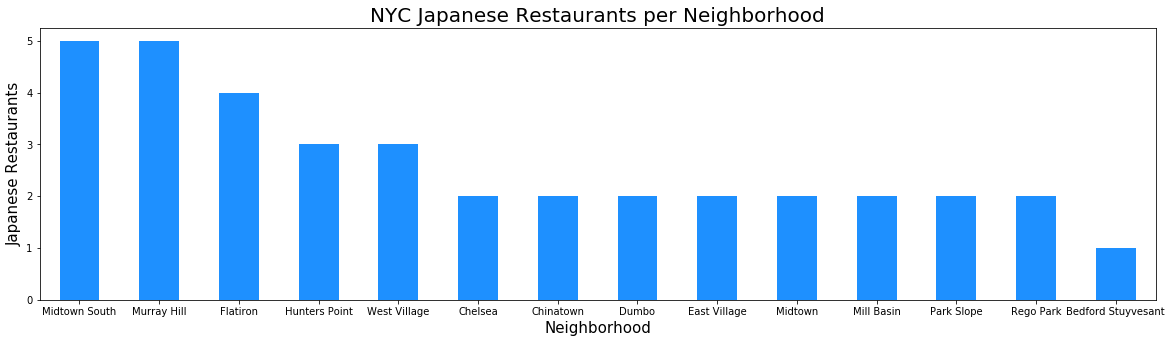

In [14]:
japanese_rest_neighborhood = 14 
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(japanese_rest_neighborhood).plot.bar(figsize=(20,5), color=clr)
plt.title('NYC Japanese Restaurants per Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

There are only 2 Japanese restaurants in East Village. In comparison to other neighborhoods it is among 7 other areas the neighborhood with the 6th most Japanese Restaurants in NYC. Hence, the neighborhood could be an interesting area to locate the new restaurant, since apparently it is popular for Japanese things, but has only 2 restaurants.

### Folium

Lets take a look at the Japanese restaurants in East Village. 

Now, we will visualize the Japanese Restaurants of our dataframe. As an orientation point, we add latitude and longitude of the restaurant Kyo Ya, 1 of the 2 Japanese restaurants in East Village.

In [15]:
latitude=40.727847
longitude=-73.982226

In [21]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # we generate the map centered around the venue

# we add a red circle marker to represent the starting point
folium.features.CircleMarker(
    [latitude, longitude],
    radius=11,
    color='red',
    popup='Kyo Ya',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.7
).add_to(venues_map)

# we add the Japanese restaurants as blue circle markers
for lat, lng, label in zip(japanese_rest_ny.Lat, japanese_rest_ny.Lng, japanese_rest_ny.Name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.7
    ).add_to(venues_map)


venues_map

Looking closely at the venue, we see there is actually only 1 Japanese restaurant in East Village. The other one named Kura has the exact same coordinates, meaning it must be the same restaurant that just changed it's name.

Now we will take a closer look at the restaurants menus.

In [17]:
column_names=['Borough', 'Neighborhood', 'MenuID', 'Name', 'Description']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    MenuID=row
    try:
        venue_menu=get_venue_menu(MenuID)
        print(venue_menu)
        id,name,menu=venue_menu.values.tolist()[0]
    except IndexError:
        print('No data available for id=',MenuID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        menuId,name,description=[0]*3
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'MenuID': menuId,
                                                'Name' : name,
                                                'Description' : description,
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.head()

{'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.', 'requestId': '5e26f4fbfb34b50028e13d98'}, 'response': {}}
Empty DataFrame
Columns: [MenuID, Name, Description]
Index: []
No data available for id= [0, 'Brooklyn', 'Kensington', '4d5c12a01e43236a87eb1583', 'Sake Sushi', 40.64238195800353, -73.98042110559473]
( 1 / 75 ) processed
{'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.', 'requestId': '5e26f5146d8c56001be3abdc'}, 'response': {}}
Empty DataFrame
Columns: [MenuID, Name, Description]
Index: []
No data available for id= [1, 'Brooklyn', 'Prospect Heights', '5cb5e5f9a35f4600255406c6', 'Maison Yaki', 40.67682226225472, -73.9648592426269]
( 2 / 75 ) processed
{'meta': {'code': 400, 'errorType': 'invalid_auth', 'errorDetail

,Borough,Neighborhood,MenuID,Name,Description
0,Staten Island,Fox Hills,0,0,0
1,Staten Island,Fox Hills,0,0,0
2,Staten Island,Fox Hills,0,0,0
3,Staten Island,Fox Hills,0,0,0
4,Staten Island,Fox Hills,0,0,0


Unfortunately it is not possible to get menu data from FourSquare with a regular account. This is why I had to abort the attempt to get menu data in order to cluster it later on. 

---

## Results

Even though the project had to be aborted because of the missing permission of a regular Foursquare account, I was able to achieve following results throughout the project:

- The borough Manhatten consists of the least neighborhoods, but has the most Japanese restaurants.
- There is no Japanese restaurant in the borough Bronx. This could be an interesting starting point for further evaluation. 
- In East Village aka little Tokyo we expected to find the most Japanese restaurants. Surprisingly, there is only one restaurant yet. There must be another reason for the neighborhood to be called little Tokyo then having Japanese restaurants. Since there is only one restaurant yet, it could be a very interesting area to propose to the client. 

---

## Discussion

Looking at the elaborated neighborhoods, there is a good chance that East Village could be an interesting neighborhood for the client to open the major Japanese restaurant. Like mentioned before though, a lot more research needs to be done to deliver a valuable recommendation for the client. Also a lot of other variables like demographic characteristics could be evaluated in a further study, but since this project is fictitious, I will stop right here.

---

## Conclusion

The project has been a good way to apply theorethical knowledge learned from the last courses of the Applied Data Science Specialization. Unfortunately FourSquare changed it's policy, so the access to valuable venue data was very limited. Hence, the course could be updated, so participants do not rely on FourSquare data in future studies.

---

 #### Sources



Nippon.com, 2016: https://www.nippon.com/en/features/h00128/japanese-restaurants-on-the-rise-abroad.html

Investopedia, 2019: https://www.investopedia.com/articles/personal-finance/012315/how-expensive-new-york-city-really.asp

Beacon Hotel, 2018: https://www.beaconhotel.com/blog/your-intro-to-all-things-japanese-in-nyc/